<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week11.do.txt --no_mako -->
<!-- dom:TITLE: April 17-21, 2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories -->

# April 17-21, 2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and Facility for Rare Isotope Beams, Michigan State University

Date: **Apr 16, 2023**

Copyright 1999-2023, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Plans for the week of April 17-21

1. Reminder on basics of the VQE method

2. Simulating efficiently Hamiltonians on quantum computers with the VQE method

a. Discussions of various gradient descent approaches

2. [VQE review article](https://www.sciencedirect.com/science/article/pii/S0370157322003118?via%3Dihub)

3. [Video of lecture TBA](https://youtu.be/)

## VQE overview

<!-- dom:FIGURE: [figures/vqe.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figures/vqe.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## VQE and efficient computations of gradients

We start with a reminder on the VQE method with applications to the
one-qubit system.  We discussed this to some detail during the week of
March 27-31. Here we revisit the one-qubit system and develop a VQE
code for studying this system using gradient descent as a method to
optimize the variational ansatz. 

We start with a simple $2\times 2$ Hamiltonian matrix expressed in
terms of Pauli $X$ and $Z$ matrices, as discussed in the project text.

We define a  symmetric matrix  $H\in {\mathbb{R}}^{2\times 2}$

$$
H = \begin{bmatrix} H_{11} & H_{12} \\ H_{21} & H_{22}
\end{bmatrix},
$$

We  let $H = H_0 + H_I$, where

$$
H_0= \begin{bmatrix} E_1 & 0 \\ 0 & E_2\end{bmatrix},
$$

is a diagonal matrix. Similarly,

$$
H_I= \begin{bmatrix} V_{11} & V_{12} \\ V_{21} & V_{22}\end{bmatrix},
$$

where $V_{ij}$ represent various interaction matrix elements.
We can view $H_0$ as the non-interacting solution

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
       H_0\vert 0 \rangle =E_1\vert 0 \rangle,
\label{_auto1} \tag{1}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
       H_0\vert 1\rangle =E_2\vert 1\rangle,
\label{_auto2} \tag{2}
\end{equation}
$$

where we have defined the orthogonal computational one-qubit basis states $\vert 0\rangle$ and $\vert 1\rangle$.

We rewrite $H$ (and $H_0$ and $H_I$)  via Pauli matrices

$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad \mathcal{E} = \frac{E_1
  + E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$

and

$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$

with $c = (V_{11}+V_{22})/2$, $\omega_z = (V_{11}-V_{22})/2$ and $\omega_x = V_{12}=V_{21}$.
We let our Hamiltonian depend linearly on a strength parameter $\lambda$

$$
H=H_0+\lambda H_\mathrm{I},
$$

with $\lambda \in [0,1]$, where the limits $\lambda=0$ and $\lambda=1$
represent the non-interacting (or unperturbed) and fully interacting
system, respectively.  The model is an eigenvalue problem with only
two available states.

Here we set the parameters $E_1=0$,
$E_2=4$, $V_{11}=-V_{22}=3$ and $V_{12}=V_{21}=0.2$.

The non-interacting solutions represent our computational basis.
Pertinent to our choice of parameters, is that at $\lambda\geq 2/3$,
the lowest eigenstate is dominated by $\vert 1\rangle$ while the upper
is $\vert 0 \rangle$. At $\lambda=1$ the $\vert 0 \rangle$ mixing of
the lowest eigenvalue is $1\%$ while for $\lambda\leq 2/3$ we have a
$\vert 0 \rangle$ component of more than $90\%$.  The character of the
eigenvectors has therefore been interchanged when passing $z=2/3$. The
value of the parameter $V_{12}$ represents the strength of the coupling
between the two states.

## Setting up the matrix

In [1]:
%matplotlib inline

from  matplotlib import pyplot as plt
import numpy as np
dim = 2
Hamiltonian = np.zeros((dim,dim))
e0 = 0.0
e1 = 4.0
Xnondiag = 0.20
Xdiag = 3.0
Eigenvalue = np.zeros(dim)
# setting up the Hamiltonian
Hamiltonian[0,0] = Xdiag+e0
Hamiltonian[0,1] = Xnondiag
Hamiltonian[1,0] = Hamiltonian[0,1]
Hamiltonian[1,1] = e1-Xdiag
# diagonalize and obtain eigenvalues, not necessarily sorted
EigValues, EigVectors = np.linalg.eig(Hamiltonian)
permute = EigValues.argsort()
EigValues = EigValues[permute]
# print only the lowest eigenvalue
print(EigValues[0])

0.9801960972814431


Now rewrite it in terms of the identity matrix and the Pauli matrix X and Z

In [2]:
# Now rewrite it in terms of the identity matrix and the Pauli matrix X and Z
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
# identity matrix
I = np.array([[1,0],[0,1]])

epsilon = (e0+e1)*0.5; omega = (e0-e1)*0.5
c = 0.0; omega_z=Xdiag; omega_x = Xnondiag
Hamiltonian = (epsilon+c)*I+(omega_z+omega)*Z+omega_x*X
EigValues, EigVectors = np.linalg.eig(Hamiltonian)
permute = EigValues.argsort()
EigValues = EigValues[permute]
# print only the lowest eigenvalue
print(EigValues[0])

0.9801960972814431


## Implementing the VQE

For a one-qubit system we can reach every point on the Bloch sphere
(as discussed earlier) with a rotation about the $x$-axis and the
$y$-axis.

We can express this mathematically through the following operations (see whiteboard for the drawing), giving us a new state $\vert \psi\rangle$

$$
\vert\psi\rangle = R_y(\phi)R_x(\theta)\vert 0 \rangle.
$$

We can produce multiple ansatzes for the new state in terms of the
angles $\theta$ and $\phi$.  With these ansatzes we can in turn
calculate the expectation value of the above Hamiltonian, now
rewritten in terms of various Pauli matrices (and thereby gates), that is compute

$$
\langle \psi \vert (c+\mathcal{E})\boldsymbol{I} + (\Omega+\omega_z)\boldsymbol{\sigma}_z + \omega_x\boldsymbol{\sigma}_x\vert \psi \rangle.
$$

We can now set up a series of ansatzes for $\vert \psi \rangle$ as
function of the angles $\theta$ and $\phi$ and find thereafter the
variational minimum using for example a gradient descent method.

To do so, we need to remind ourselves about the mathematical expressions for
the rotational matrices/operators.

$$
R_x(\theta)=\cos{\frac{\theta}{2}}\boldsymbol{I}-\imath \sin{\frac{\theta}{2}}\boldsymbol{\sigma}_x,
$$

and

$$
R_y(\phi)=\cos{\frac{\phi}{2}}\boldsymbol{I}-\imath \sin{\frac{\phi}{2}}\boldsymbol{\sigma}_y.
$$

In [3]:
# define the rotation matrices
# Define angles theta and phi
theta = 0.5*np.pi; phi = 0.2*np.pi
Rx = np.cos(theta*0.5)*I-1j*np.sin(theta*0.5)*X
Ry = np.cos(phi*0.5)*I-1j*np.sin(phi*0.5)*Y
#define basis states
basis0 = np.array([1,0])
basis1 = np.array([0,1])

NewBasis = Ry @ Rx @ basis0
print(NewBasis)
# Compute the expectation value
#Note hermitian conjugation
Energy = NewBasis.conj().T @ Hamiltonian @ NewBasis
print(Energy)

[0.67249851+0.21850801j 0.21850801-0.67249851j]
(2-1.187159067031975e-16j)


Not an impressive results. We set up now a loop over many angles $\theta$ and $\phi$ and compute the energies

In [4]:
# define a number of angles
n = 20
angle = np.arange(0,180,10)
n = np.size(angle)
ExpectationValues = np.zeros((n,n))
for i in range (n):
    theta = np.pi*angle[i]/180.0
    Rx = np.cos(theta*0.5)*I-1j*np.sin(theta*0.5)*X
    for j in range (n):
        phi = np.pi*angle[j]/180.0
        Ry = np.cos(phi*0.5)*I-1j*np.sin(phi*0.5)*Y
        NewBasis = Ry @ Rx @ basis0
        Energy = NewBasis.conj().T @ Hamiltonian @ NewBasis
        Edifference=abs(np.real(EigValues[0]-Energy))
        ExpectationValues[i,j]=Edifference

print(np.min(ExpectationValues))

0.01575557799303584


Clearly, this is not the very best way of proceeding. Rather, here we
could try to find the optimal values for the parameters $\theta$ and
$\phi$ through computation of their respective gradients and thereby
find the minimum as function of the optimal angles $\hat{\theta}$ and
$\hat{\phi}$.

Let us now implement a classical gradient descent algorithm to the computation of the energies. 
We will follow closely  <https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331> in order to calculate gradients of the Hamiltonian.

## Gradient descent and calculations of gradients

In order to optimize the VQE ansatz, we need to compute derivatives
with respect to the variational parameters.  Here we develop first a
simpler approach tailored to the one-qubit case. For this particular
case, we have defined an ansatz in terms of the Pauli rotation
matrices. These define an arbitrary one-qubit state on the Bloch
sphere through the expression

$$
\vert\psi\rangle = \vert \psi(\theta,\phi)\rangle =R_y(\phi)R_x(\theta)\vert 0 \rangle.
$$

Each of these rotation matrices can be written in a more general form as

$$
R_{i}(\gamma)=\exp{-(\imath\frac{\gamma}{2}\sigma_i)}=\cos{(\frac{\gamma}{2})}\boldsymbol{I}-\imath\sin{(\frac{\gamma}{2})}\boldsymbol{\sigma}_i,
$$

where $\sigma_i$ is one of the Pauli matrices $\sigma_{x,y,z}$. 

It is easy to see that the derivative with respect to $\gamma$ is

$$
\frac{\partial R_{i}(\gamma)}{\partial \gamma}=-\frac{\gamma}{2}\boldsymbol{\sigma}_i R_{i}(\gamma).
$$

We can now calculate the derivative of the expectation value of the
Hamiltonian in terms of the angles $\theta$ and $\phi$. We have two
derivatives

$$
\frac{\partial}{\partial \theta}\left[\langle \psi(\theta,\phi) \vert \boldsymbol{H}\vert \psi(\theta,\phi)\rangle\right]=\frac{\partial}{\partial \theta}\left[\langle\boldsymbol{H}(\theta,\phi)\rangle\right]=\langle \psi(\theta,\phi) \vert \boldsymbol{H}(-\frac{\imath}{2}\boldsymbol{\sigma}_x\vert \psi(\theta,\phi)\rangle+\hspace{0.1cm}\mathrm{h.c},
$$

and

$$
\frac{\partial }{\partial \phi}\left[\langle \psi(\theta,\phi) \vert \boldsymbol{H}\vert \psi(\theta,\phi)\rangle\right]=\frac{\partial}{\partial \phi}\left[\langle\boldsymbol{H}(\theta,\phi)\rangle\right]=\langle \psi(\theta,\phi) \vert \boldsymbol{H}(-\frac{\imath}{2}\boldsymbol{\sigma}_y\vert \psi(\theta,\phi)\rangle+\hspace{0.1cm}\mathrm{h.c}.
$$

This means that we have to calculate two additional expectation values
in addition to the expectation value of the Hamiltonian itself.  In
our first attempt, we will compute these expectation values in a brute
force way, performing the various matrix-matrix and matrix-vector
multiplications. As the reader quickly will see, this approach becomes
unpractical if we venture beyond some few qubits.  We will try to
rewrite the above derivatives in a smarter way, see [the article by
Maria Schuld et
al](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331).

## Basics of gradient descent and stochastic gradient descent

In order to implement the above equations, we need to remind the
reader about basic elements of various optimization approaches. Our
main focus here will be various gradient descent approaches, with and
without momentum and various approaches for approximating the second
derivatives via adaptive methods.

The material here is covered by the lectures from [FYS-STK4155 on gradient optimization](https://github.com/CompPhysics/MachineLearning/blob/master/doc/pub/week39/ipynb/week39.ipynb).

We will repeat some of the basic ingredients from these lectures.

## Computing quantum gradients in a smarter way

This material will added and is based on [the article of Schuld et al.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331).

## A smarter way of doing this

The above approach means that we are setting up several matrix-matrix
and matrix-vector multiplications. Although straight forward it is not
the most efficient way of doing this, in particular in case the
matrices become large (and sparse). But there are some more important
issues.

In a physical realization of these systems we cannot just multiply the
state with the Hamiltonian. When performing a measurement we can only
measure in one particular direction. For the computational basis
states which we have, $\vert 0\rangle$ and $\vert 1\rangle$, we have
to measure along the bases of the Pauli matrices and reconstruct the
eigenvalues from these measurements.

From our earlier discussions we know that the Pauli $Z$ matrix has the above basis states as eigen states through

$$
\boldsymbol{\sigma}_z\vert 0 \rangle = \boldsymbol{Z}\vert 0 \rangle=+1\vert 0 \rangle,
$$

and

$$
\boldsymbol{\sigma}_z\vert 1 \rangle = \boldsymbol{Z}\vert 1 \rangle=-1\vert 1 \rangle,
$$

with eigenvalue $-1$.

For the Pauli $X$ matrix on the other hand we have

$$
\boldsymbol{\sigma}_x\vert 0 \rangle = \boldsymbol{X}\vert 0 \rangle=+1\vert 1 \rangle,
$$

and

$$
\boldsymbol{\sigma}_x\vert 1 \rangle = \boldsymbol{X}\vert 1 \rangle=-1\vert 0 \rangle,
$$

with eigenvalues $1$ in both cases. The latter two equations tell us
that the computational basis we have chosen, and in which we will
prepare our states, is not an eigenbasis of the $\sigma_x$ matrix.

We will thus try to rewrite the Pauli $X$ matrix in terms of a Pauli $Z$ matrix. Fortunately this can be done using the Hadamard matrix twice, that is

$$
\boldsymbol{X}=\boldsymbol{\sigma}_x=\boldsymbol{H}\boldsymbol{Z}\boldsymbol{H}.
$$

The Pauli $Y$ matrix can be written as

$$
\boldsymbol{Y}=\boldsymbol{\sigma}_y=\boldsymbol{H}\boldsymbol{S}^{\dagger}\boldsymbol{Z}\boldsymbol{H}\boldsymbol{S},
$$

where $S$ is the phase matrix

$$
S = \begin{bmatrix} 1 & 0 \\ 0 & \imath \end{bmatrix}.
$$

From here and on we will denote the Pauli matrices by $X$, $Y$ and $Z$ and we can write the expectation value of the Hamiltonian as

$$
\langle \psi \vert (c+\mathcal{E})\boldsymbol{I} + (\Omega+\omega_z)\boldsymbol{Z} + \omega_x\boldsymbol{H}\boldsymbol{Z}\boldsymbol{H}\vert \psi \rangle,
$$

which we can rewrite as

$$
(c+\mathcal{E})\langle \psi \vert \boldsymbol{I}\vert \psi \rangle+(\Omega+\omega_z)\langle \psi \vert \boldsymbol{Z}\vert \psi \rangle+\omega_x\langle \psi \boldsymbol{H}\vert \boldsymbol{Z}\vert\boldsymbol{H}\psi \rangle.
$$

The first and second term are to easy to perform a measurement on since we we just need to compute
$\langle \psi\vert \boldsymbol{I}\vert \psi\rangle$ and $\langle \psi\vert \boldsymbol{Z}\vert \psi\rangle$.
For the final term we need just to add the action of the Hadamard matrix and we are done.

**To do:** Set up codes for this using gradient descent and perform a series of measumerents

## Two-qubit system and the VQE

We extend now the system  to a two-qubit system with the following computational
basis states and Hamiltonian matrix written out in terms of Pauli spin
matrices.

This system can be thought of as composed of two subsystems
$A$ and $B$. Each subsystem has computational basis states

$$
\vert 0\rangle_{\mathrm{A,B}}=\begin{bmatrix} 1 & 0\end{bmatrix}^T \hspace{1cm} \vert 1\rangle_{\mathrm{A,B}}=\begin{bmatrix} 0 & 1\end{bmatrix}^T.
$$

The subsystems could represent single particles or composite many-particle systems of a given symmetry.
This leads to the many-body computational basis states

$$
\vert 00\rangle = \vert 0\rangle_{\mathrm{A}}\otimes \vert 0\rangle_{\mathrm{B}}=\begin{bmatrix} 1 & 0 & 0 &0\end{bmatrix}^T,
$$

and

$$
\vert 01\rangle = \vert 0\rangle_{\mathrm{A}}\otimes \vert 1\rangle_{\mathrm{B}}=\begin{bmatrix} 0 & 1 & 0 &0\end{bmatrix}^T,
$$

and

$$
\vert 10\rangle = \vert 1\rangle_{\mathrm{A}}\otimes \vert 0\rangle_{\mathrm{B}}=\begin{bmatrix} 0 & 0 & 1 &0\end{bmatrix}^T,
$$

and finally

$$
\vert 11\rangle = \vert 1\rangle_{\mathrm{A}}\otimes \vert 1\rangle_{\mathrm{B}}=\begin{bmatrix} 0 & 0 & 0 &1\end{bmatrix}^T.
$$

These computational basis states define also the eigenstates of the non-interacting  Hamiltonian

$$
H_0\vert 00 \rangle = \epsilon_{00}\vert 00 \rangle,
$$

$$
H_0\vert 10 \rangle = \epsilon_{10}\vert 10 \rangle,
$$

$$
H_0\vert 01 \rangle = \epsilon_{01}\vert 01 \rangle,
$$

and

$$
H_0\vert 11 \rangle = \epsilon_{11}\vert 11 \rangle.
$$

The interacting part of the Hamiltonian $H_{\mathrm{I}}$ is given by the tensor product of two $\sigma_x$ and $\sigma_z$  matrices, respectively, that is

$$
H_{\mathrm{I}}=H_x\sigma_x\otimes\sigma_x+H_z\sigma_z\otimes\sigma_z,
$$

where $H_x$ and $H_z$ are interaction strength parameters. Our final Hamiltonian matrix is given by

$$
\boldsymbol{H}=\begin{bmatrix} \epsilon_{00}+H_z & 0 & 0 & H_x \\
                       0  & \epsilon_{10}-H_z & H_x & 0 \\
		       0 & H_x & \epsilon_{01}-H_z & 0 \\
		       H_x & 0 & 0 & \epsilon_{11} +H_z \end{bmatrix}.
$$

## Switching to Qiskit (notes developed by Stian Bilek)

In [5]:
import numpy as np
import qiskit as qk
from scipy.optimize import minimize


# Initialize registers and circuit
n_qubits = 1 #Number of qubits
n_cbits = 1 #Number of classical bits (the number of qubits you want to measure at the end of the circuit)
qreg = qk.QuantumRegister(n_qubits) #Create a quantum register
creg = qk.ClassicalRegister(n_cbits) #Create a classical register
circuit = qk.QuantumCircuit(qreg,creg) #Create your quantum circuit
circuit.draw() #Draw circuit. It is empty
# Perform operations on qubit
circuit.x(qreg[0]) #Applies a Pauli X gate to the first qubit in the quantum register
circuit.draw()
# Chose a qubit to measure and encode the results to a classical bit
#Measure the first qubit in the quantum register
#and encode the results to the first qubit in the classical register
circuit.measure(qreg[0],creg[0])
circuit.draw()
# Execute circuit

backend = qk.Aer.get_backend('qasm_simulator') 
#This is the device you want to use. It is an ideal simulation of a quantum device


job = backend.run(circuit,shots=1000) #Run the circuit 1000 times
result = job.result()
counts = result.get_counts()
print(counts)
circuit.clear()
circuit.draw()

circuit.h(qreg[0]) #Apply a Hadamard gate to the first qubit of the quantum register
circuit.measure(qreg,creg)
print(circuit.draw())
job = backend.run(circuit,shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
circuit.clear()

{'1': 1000}
      ┌───┐┌─┐
  q0: ┤ H ├┤M├
      └───┘└╥┘
c0: 1/══════╩═
            0 
{'0': 471, '1': 529}


Create a two-qubit circuit and set up a Bell state

In [6]:
n_qubits = 2
n_cbits = 2
qreg = qk.QuantumRegister(n_qubits)
creg = qk.ClassicalRegister(n_cbits)
circuit = qk.QuantumCircuit(qreg,creg)
circuit.draw()
circuit.h(qreg[0])
circuit.cx(qreg[0],qreg[1])

This is a controlled operation. Apply a Pauli $X$ gate to the second qubit (qreg[1]) if the first qubit (qreg[0])
is in the $|1\rangle$ state. Else do nothing

In [7]:
circuit.draw()
circuit.measure(qreg,creg)
circuit.draw()
job = backend.run(circuit,shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
circuit.clear()

{'00': 498, '11': 502}


Apply rotation to qubit

In [8]:
theta = np.pi/3
circuit.rx(theta, qreg[0]) #R_x(theta) rotation on the first qubit (qreg[0])
circuit.measure(qreg,creg)
print(circuit.draw())
job = backend.run(circuit,shots=1000)
result = job.result()
counts = result.get_counts()
circuit.clear()
print(counts)

      ┌─────────┐┌─┐
q1_0: ┤ Rx(π/3) ├┤M├
      └───┬─┬───┘└╥┘
q1_1: ────┤M├─────╫─
          └╥┘     ║ 
c1: 2/═════╩══════╩═
           1      0 
{'00': 743, '01': 257}


Find the lowest eigenvalue of $$ H = c_1 Z_0 + c_2 Z_1 + c_3 X_0 Y_1 $$ 
We will use $$<\psi|H|\psi> = c_1<\psi|Z_0|\psi> + c_2<\psi|Z_1|\psi> + c_3<\psi|X_0Y_1|\psi> $$

In [9]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
H = np.kron(Z,I) + np.kron(I,Z) + np.kron(X,Y)
eigvals,eigvecs = np.linalg.eigh(H)
print(eigvals[0])

c_1 = 1
c_2 = 1
c_3 = 1

h_1 = [c_1,[0],['z']]
h_2 = [c_2,[1],['z']]
h_3 = [c_3,[0,1],['x','x']]
H = [h_1,h_2,h_3]

-2.23606797749979


Create ansatz

In [10]:
def ansatz(theta,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    for i in range(n_qubits):
        circuit.ry(theta[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)
qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
circuit.h(qreg[:2])
print('Before ansatz')
print(circuit.draw())
theta = np.random.randn(2)
n_qubits = 2
circuit = circuit.compose(ansatz(theta,n_qubits))
print('After ansatz')
circuit.draw()

Before ansatz
      ┌───┐
q2_0: ┤ H ├
      ├───┤
q2_1: ┤ H ├
      └───┘
After ansatz


┌───┐ ┌────────────┐      
q2_0: ┤ H ├─┤ Ry(0.2849) ├───■──
      ├───┤┌┴────────────┴┐┌─┴─┐
q2_1: ┤ H ├┤ Ry(0.056969) ├┤ X ├
      └───┘└──────────────┘└───┘

Change measurement basis

In [11]:
def basis_change(h_i,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            circuit.h(qreg[qubit])
        if operator == 'y':
            circuit.sdg(qreg[qubit])
            circuit.h(qreg[qubit])
    return(circuit)
n_qubits = 2
qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
theta = np.random.randn(n_qubits)
circuit = circuit.compose(ansatz(theta,n_qubits))
print('Ansatz circuit')
circuit.draw()
circuit = circuit.compose(basis_change(H[2],n_qubits))
print('After basis transformation:')
print(circuit.draw())

Ansatz circuit
After basis transformation:
      ┌──────────────┐     ┌───┐
q4_0: ┤ Ry(-0.19662) ├──■──┤ H ├
      └┬────────────┬┘┌─┴─┐├───┤
q4_1: ─┤ Ry(1.4756) ├─┤ X ├┤ H ├
       └────────────┘ └───┘└───┘


Get energy for given rotational parameters, theta

In [12]:
def get_energy(theta):
    n_qubits = 2
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))
    circuit_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = qk.ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 10000
    job = backend.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)
get_energy(theta)

1.9792

Minimize energy with Scipy

In [13]:
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)


# ## We might need a more flexible ansatz

def ansatz(theta,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    idx = 0
    for i in range(n_qubits):
        circuit.ry(theta[idx],qreg[i])
        idx += 1
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    for i in range(n_qubits):
        circuit.rx(theta[idx],qreg[i])
        idx += 1
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)
theta = np.random.randn(4)
res = minimize(get_energy, theta, method='Powell',tol=1e-16)
get_energy(res.x)

-1.9422

Then we minimize energy with gradient descent

$$
\frac{\partial E (\theta_1,\dots,\theta_i,\dots,\theta_p)}{\partial \theta_i} = \frac{E(\theta_1,\dots,\theta_i + \pi/2,\dots, \theta_p) - E(\theta_1,\dots, \theta_i - \pi/2,\dots, \theta_p}{2}.
$$

In [14]:
epochs = 200
theta = np.random.randn(4)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 0.9910000000000001
1 0.8856
2 0.7816
3 0.6399999999999999
4 0.5287999999999999
5 0.4016
6 0.28140000000000004
7 0.1796
8 0.042400000000000077
9 -0.10279999999999997
10 -0.2245999999999999
11 -0.3631999999999999
12 -0.48640000000000005
13 -0.6323999999999999
14 -0.7352000000000001
15 -0.8394
16 -0.9950000000000001
17 -1.0697999999999999
18 -1.1956
19 -1.282
20 -1.3342
21 -1.4312
22 -1.4644
23 -1.5246
24 -1.5598
25 -1.58
26 -1.6228
27 -1.6583999999999999
28 -1.6680000000000001
29 -1.6832
30 -1.7174
31 -1.7306
32 -1.7614
33 -1.7686000000000002
34 -1.7628
35 -1.791
36 -1.7875999999999999
37 -1.8132000000000001
38 -1.8184
39 -1.8396000000000001
40 -1.8461999999999998
41 -1.8634
42 -1.8518000000000001
43 -1.8758
44 -1.8687999999999998
45 -1.8922000000000003
46 -1.9173999999999998
47 -1.91
48 -1.8969999999999998
49 -1.8948
50 -1.91
51 -1.9209999999999998
52 -1.9414
53 -1.9332
54 -1.9335999999999998
55 -1.962
56 -1.9712
57 -1.9668
58 -1.9724
59 -1.95
60 -1.9651999999999998
61 -1.980600000000

## Moving to the Lipkin model

To construct an efficient ansatz, we must determine the subspace
within which the Hamiltonian lives. To begin, note that particles are
only ever moved between energy levels in pairs. This implies that all
possible states have a Hamming weight of constant parity (odd or
even); this is the same as the signature $r$ being conserved. Further,
note that the Hamiltonian's coefficients ($\epsilon$ and $V$) are
state independent (do not depend on the indices $n$ or $m$) as the
states labeled by these indices are degenerate and thus have the same
energy level. Thus, the Hamiltonian treats all states with the same
number of excited particles (Hamming weight of the state) as the
same. Therefore, the following ansatz forms exactly cover the subspace
within which the $N$-degenerate Hamiltonian explores:

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\vert \psi_{\text{even}}\rangle=\sum_{k=0}^{\lfloor n/2 \rfloor}c_{2k}\vert D^n_{2k}\rangle,
\label{_auto3} \tag{3}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation} 
\vert \psi_{\text{odd}}\rangle=\sum_{k=0}^{\lfloor n/2 \rfloor}c_{2k+1}\vert D^n_{2k+1}\rangle.
\label{_auto4} \tag{4}
\end{equation}
$$

Here $\vert D^n_k\rangle$ represents a Dicke state which is defined as equal superposition of all $n$-qubit states with Hamming weight $k$. That is

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
\vert D^n_k\rangle= \frac{1}{\sqrt{{n \choose k}}}\sum_{x\in h^n_k}\vert x\rangle,
\label{_auto5} \tag{5}
\end{equation}
$$

where $h^n_k= \{\vert x\rangle \ | \ \text{l}(x) = n, \ \text{wt}(x) = k\}$. There are two ways we can think of to prepare such ansatz: The first is to prepare them exactly as it is known how to deterministically prepare Dicke states with linear depth. The reference provides an algorithm for preparing a set of gates $U^n_k$ that prepares a Dicke state from a product state of Hamming weight $k$; that is

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
U^n_k\vert 1\rangle^{\otimes k}\vert 0\rangle^{\otimes n-k}=\vert D^n_k\rangle.
\label{_auto6} \tag{6}
\end{equation}
$$

It then describes how to one can create an arbitrary superposition of
Dicke states, which we modify here to restrict ourselves to a Hamming
weight of constant parity. The circuit to construct such a state (for
the $k=6$ case, as an example) is given below

In [15]:
import numpy as np
import qiskit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
from matplotlib.pyplot import figure
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, assemble
from qiskit.providers.aer.noise import NoiseModel
import pylatexenc
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM
from qiskit.opflow import AerPauliExpectation
from qiskit import IBMQ
import cmath
import pandas as pd
from scipy.sparse import diags
import numpy.linalg as LA
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
pi=np.pi

In [16]:
#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

#one body expectation value
def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1) # Since the collective space is Omega+1
  return E*np.diag(m) #return a matrix where its diagonal elemens are epsilon*K_0

#two body expectation value
def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=complex)
  right = np.zeros(len(m)-2,dtype=complex)
  diag = np.zeros(len(m),dtype=complex)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1)) #calculate Clebsch-Gordan Coefficients 
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray() #return a matrix where its off digonal elements are (1/2)V(K^2_+ + K^2_-)

#full expectation value
def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H) # find the eigenvalues of the Hamiltonian
  return e,H

#converts chi to V
def Vp(E,omega,chi):
  return (chi*E)/(omega-1)

In [17]:
#parameters
E = 1
chi = np.arange(0,2.1,0.1)
omega = 2

EV0 = []
EV1 = []
EV2 = []
Ham = []
for i in chi:
  v = Vp(E,omega,i)
  EigenV,H = quasi_spin(E,v,omega) #return eigenvalues and Hamiltonian
  Ham.append(H)
  EV0.append(EigenV[0])
  EV1.append(EigenV[1])
  EV2.append(EigenV[2])

In [18]:
matrix = pd.DataFrame(Ham[5].real)
print('Hamiltonian matrix')
matrix.head()

Hamiltonian matrix


,0,1,2
0,-1.0,0.0,-0.5
1,0.0,0.0,0.0
2,-0.5,0.0,1.0


Text(0.5, 1.0, '$\\Omega=2$ exact Lipkin Model')

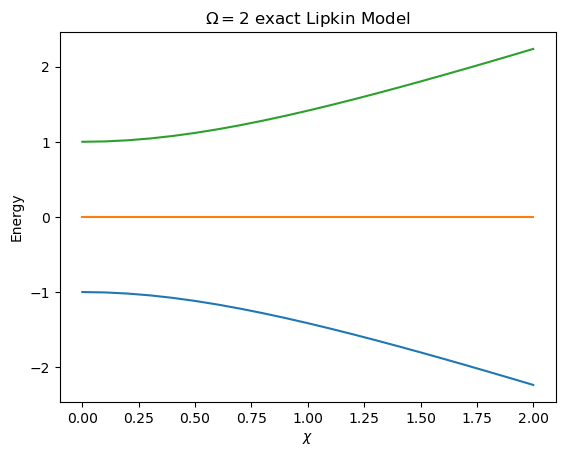

In [19]:
plt.plot(chi,EV0)
plt.plot(chi,EV1)
plt.plot(chi,EV2)
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.title('$\Omega=2$ exact Lipkin Model')

In [20]:
def LM_circuit():
    theta = Parameter('theta')
    QC = QuantumCircuit(2)
    QC.ry(2*(theta-np.pi/2),0)
    QC.cnot(0,1)
    return QC

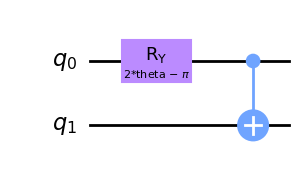

In [21]:
QC = LM_circuit()
QC.draw(output='mpl')

### VQE method

For this method, we will be using Qiskit's VQE function, where we specifiy 
* Quantum circuit

a. Optimizer

b. Quantum instance (i.e. which backend). Here we will be using the "qasm_simulator" 

c. Initial point (i.e. $\theta$ search space)

d. Hamiltonian/measurement basis

To define the Hamiltonian, we will use the Qiskit Pauli operator functions
I,Z,X,Y.  In this method, for a given $\chi$, we will do a search over
$\theta$ from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$ and picking out the
minimum energy value

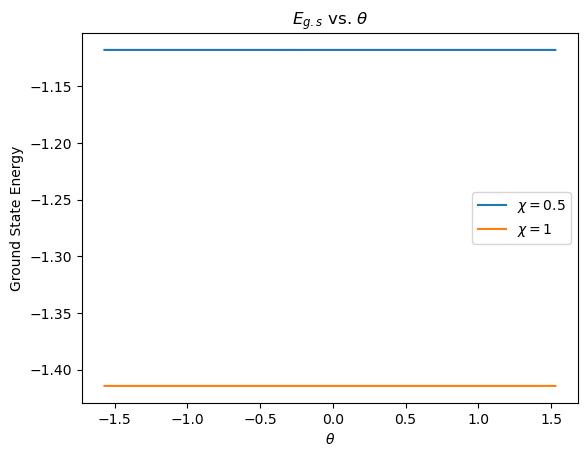

In [22]:
#sim1 min example
sim = Aer.get_backend('qasm_simulator')
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000) #optimizer for VQE
epsilon = 1
omega = 2
chi2 = [0.5,1]

t = np.arange(-pi/2,pi/2,0.05) #0.1 step size finishs pretty fast
energy = []
for x in chi2:
    ev = []
    v = Vp(epsilon,omega,x)
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) + 0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)
        ev.append(result.eigenvalue)
    energy.append(ev)


plt.plot(t,energy[0],label='$\chi=0.5$')
plt.plot(t,energy[1],label='$\chi=1$')
plt.xlabel('$\\theta$')
plt.ylabel('Ground State Energy')
plt.title('$E_{g.s}$ vs. $\\theta$')
plt.legend()

In [23]:
epsilon = 1
omega = 2
chi3 = np.arange(0,2.1,0.1)
t = np.arange(-pi/2,pi/2,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi3:
    v = Vp(epsilon,omega,x)
    ev = []
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)

        ev.append(result.eigenvalue)
    LM_sim.append(min(ev))

plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi3,LM_sim,label='QC sim',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega=2$')
plt.legend()

### VQE method using Qiskit

For this method, we will be using Qiskit's VQE function, where we specifiy 
1. Quantum circuit

2. Optimizer

3. Quantum instance (i.e. which backend). Here we will be using the "statevector_simulator" 

4. Hamiltonian/measurement basis

In [23]:
epsilon = 1
omega = 2
chi5 = np.arange(0,2.1,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi5:
    v = Vp(epsilon,omega,x)
    H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z )-0.5 * v * ( X ^ X ) + 0.5 * v * ( Y ^ Y )
    vec = Aer.get_backend('statevector_simulator')
    vqe = VQE(ansatz=LM_circuit(),optimizer=adam,quantum_instance=vec,expectation=AerPauliExpectation())
    result = vqe.compute_minimum_eigenvalue(H)
    LM_sim.append(result.eigenvalue)


plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi5,LM_sim,label='QC state vec',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title('$\Omega=2$')
plt.legend()

NameError: name 'exact' is not defined